# EDA 与 Momentum 建模（重构版）
本重构版将 notebook 分为：1) 环境与数据加载 2) 快速数据健康检查 3) Baseline（逻辑回归）4) 关键 EDA（3–6 图 & ≥5 insights）5) 简化 DBN 推断（单隐状态）6) OOS 评估与后验检验 7) 导出与总结。

## 1) 题目拆解与任务要求

题目用温网决赛“控制权多次换边、持续很多分甚至很多局的 swings”引出 momentum：它被球员感知，但难以度量，也不清楚哪些事件会创造/改变它。

你要完成的任务是（官方 bullets）：

1. **建模 flow**：随逐分发生，识别“此刻谁更占优、强度多大”，并可视化整场走势；同时注意发球方优势要考虑。
2. **检验教练质疑**：教练认为 swings/连胜只是随机，用你的模型/指标评估。
3. **预测反转 + 找因素 + 给建议**：用至少一场比赛预测 flow 即将从一方转向另一方；指出相关因素，并给备战建议。
4. **外推泛化**：在其他比赛测试效果，分析缺失因素，讨论能否泛化到女单、不同场地甚至乒乓。
5. **交付**：≤25页报告 + 1–2页教练 memo + summary sheet/目录/参考文献；如用AI要附 AI use report。

---

## 2) 数据可提取内容

数据是**逐分（point-by-point）序列**。题面明确字段范式包括：谁发球、谁得分、盘/局/比分、回合数、跑动距离、发球速度与落点、破发点等。

结合题面给的 examples，你至少能提取四大类（你之前总结得很对）：

* **上下文比分/阶段**：`set_no, game_no, point_no, p1_score/p2_score, p1_games/p2_games, p1_sets/p2_sets` 等（题面例子逐列解释了这些如何表示“第几盘第几局第几分、比分多少”）。
* **发球情况**：`server, serve_no, speed_mph, serve_width, serve_depth, return_depth`（题面例子给了一个完整解释）。
* **体能表现**：`p1_distance_run, p2_distance_run, rally_count`（题面例子同样给了定义）。
* **技术事件与得分方式**：winner/ace/double fault/unforced error/net point/break point 等（题面明确“这些列让我们判断这一分怎么赢的/是否破发点”等）。

> 建模时要把特征分成两套：
> **当下预测可用**（开打前/发球后立刻可知：server、比分、阶段、历史滚动统计） vs **事后解释可用**（winner/UE/跑动/回合数属于本分结束后才知道，更适合解释“为什么反转”）。

---

## 3) EDA 要讲的故事（用来揭示建模动机）

EDA 的“主线叙事”建议是：**逐分数据强结构依赖 + 发球优势是强混杂 + 关键分压力导致非平稳 + swings 需要一个动态隐状态来解释**。

你可以按 3–6 张关键图把故事讲圆（summary.md 也建议至少 3–6 张关键 EDA 图、并产出≥5条 insight 指向建模选择）。L1-L3

推荐的 EDA “故事板”：

1. **发球优势（必须先证明是混杂）**

   * 图：server=1 vs server=2 的赢分率差异；分一发/二发。
   * 结论导向：如果不控制 server，你的 momentum 会“学到”发球轮转而不是走势（题面也提醒发球方赢分概率高）。

2. **关键分/比分压力的结构性变化（非 i.i.d.）**

   * 图：break point / deuce / tiebreak 条件下的赢分率变化；盘末局末的变化。
   * 结论导向：点与点不是独立同分布，比分状态会改变胜率（summary.md也强调“强依赖结构”）。

3. **swings 的“存在性可视化”（不等于证明）**

   * 图：某场比赛的“滚动赢分率/滚动优势”曲线；标出盘局边界。
   * 结论导向：我们确实看到“持续很多分/局的优势段 + 方向改变”，这对应题面叙事中的 swings。

4. **潜在触发器线索（解释反转的候选因素）**

   * 图：反转点前后的 serve speed/一发比例、rally_count、跑动差、UE/DF 率变化（用“反转窗口”对齐）。
   * 结论导向：反转可能由发球状态/疲劳/关键分事件驱动，所以需要“隐状态 + 外生输入”的动态模型，而不是静态回归。

---

## 4) DBN 模型（从可提取内容出发，momentum 为标量）

我们把题面 momentum 直接定义成一个**标量隐状态** (M_t)：表示“此刻控制权/净优势强度（带方向）”。这对应题面“优势会持续 many points/games 且会 change of direction”。

### 4.1 变量与特征怎么进模型

* 观测结果：(y_t\in{0,1})：第 (t) 分 P1 是否赢（point_victor）。
* 控制变量（必须）：
  (c_t=)(server_t, score_state_t, importance_t)。

  * server 来自 `server`；score_state 来自盘/局/分与比分列；importance 用 break point / deuce-AD / tiebreak 构造。L12-L27
* 外生输入（解释动量演化）：
  (u_{t-1}=)(serve_form_{t-1}, fatigue_{t-1})

  * serve_form：历史窗口的一发比例、均速、落点稳定性（由 `serve_no/speed_mph/serve_width/serve_depth` 汇总）。
  * fatigue：历史窗口的回合数与跑动（由 `rally_count` 与 distance_run 汇总）。

### 4.2 DBN 的生成模型（最简、易解释、适合变分推断）

**状态演化（momentum 的“惯性 + 被因素驱动”）**
[
M_t \mid M_{t-1},u_{t-1} \sim \mathcal N\big(\rho M_{t-1}+\eta^\top u_{t-1},\ \sigma_M^2\big)
]

* (\rho)：动量持续性（是否“能持续很多分/局”的核心参数）
* (\eta)：发球状态/疲劳是否推动动量变化（解释“为什么会反转”）

**观测模型（当分胜率；控制变量清晰）**
[
y_t \mid M_t,c_t \sim \mathrm{Bernoulli}\Big(\sigma(\beta^\top c_t + \alpha M_t)\Big)
]

* (\beta^\top c_t)：把发球优势与比分压力“控制住”，避免混淆
* (\alpha M_t)：动量对当分胜率的净贡献

**推断方式：变分推断（VI）**
按照 summary.md 的统一模板，就是“隐状态→观测→贝叶斯更新”，并输出不确定性区间。
我们用 (q(M_{1:T})) 近似后验（可先用 mean-field 正态，再升级成相邻相关的结构化 VI），优化 ELBO 得到每一分的 (M_t) 后验均值与置信带。

---

## 5) 接下来应该做什么（按可落地的执行清单）

**Step 0｜确定评估协议（先定死，防止“假提升”）**

* 以“按时间顺序”的 forward / rolling split 做验证（逐分序列强依赖）。

**Step 1｜做 baseline（必须有对照）**

* 最小 baseline：只用 server + score/importance 的逻辑回归预测每分胜率。
* 指标：log loss / Brier + 一张校准图（概率预测必须看校准）。

**Step 2｜完成 EDA 故事板并产出“insight→建模选择映射”**

* 至少 3 张关键图、≥5 条 insight，并标注分别推动了哪些模型设计（控制 server、建隐状态、关键分权重等）。

**Step 3｜实现 DBN + VI（先简后繁）**

* 先做：单隐状态 (M_t)+线性高斯转移+logistic 观测；输出 (M_t) 曲线与置信带（flow 可视化）。
* 再做：关键分交互（让动量在 break point/tiebreak 更“放大”），看预测与解释是否改善。

**Step 4｜“momentum 是否随机”的检验（对应任务 2）**

* Null：(\alpha=0) 或 (\rho=0)（无动量/无持续性）
* Alt：(\alpha\neq0,\rho>0)
* 用 out-of-sample log loss + 后验区间证明（(\rho) 的 credible interval 是否显著大于 0）来回答教练质疑。

**Step 5｜反转预测与 memo（对应任务 3）**

* 定义“反转事件”：(\mathbb E[M_t]) 过零或 (\Pr(M_{t+1}M_t<0)) 超阈值；
* 输出“反转风险概率 + 触发因素贡献”（serve_form、fatigue 在转移方程里的作用）。

**Step 6｜外推与泛化讨论（对应任务 4）**

* 在其他比赛跑一遍，比较哪些比赛 (\rho) 更大/更小、哪些因素更关键，并讨论为何（场地、球员风格、数据缺失等）。


In [7]:
# Cell 1: imports, settings, data paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from pathlib import Path

# DATA_DIR: 假定 notebook 在同一目录下运行；如果你在 VSCode 中，请确保工作目录为该 notebook 所在目录
DATA_DIR = os.path.dirname(os.path.abspath("EDA.ipynb")) if os.path.exists('EDA.ipynb') else os.getcwd()
RAW_FP = os.path.join(DATA_DIR, '2024_Wimbledon_featured_matches.csv')
DICT_FP = os.path.join(DATA_DIR, '2024_data_dictionary.csv')
FEATURES_FP = os.path.join(DATA_DIR, 'match_time_series_features_fixed.csv')
print('DATA_DIR =', DATA_DIR)
# 读取（延迟加载在下一单元）

DATA_DIR = e:\Documents\Mathematical-Modelling\2024C


In [15]:
# Cell 2: load data (safe)
def safe_read(fp, **kwargs):
    if os.path.exists(fp):
        return pd.read_csv(fp, **kwargs)
    else:
        print('Missing:', fp)
        return pd.DataFrame()

df = safe_read(RAW_FP)
data_dict = safe_read(DICT_FP)
feats = safe_read(FEATURES_FP)
print('df shape:', df.shape, 'features shape:', feats.shape)

# quick guard: ensure minimal columns exist for downstream steps
required = ['match_id','player1','player2']
for c in required:
    if c not in df.columns:
        print('Warning: missing column', c)

# construct per-point win label if possible
if 'p1_points_won' in df.columns and 'p2_points_won' in df.columns:
    df = df.copy()
    df['p1_delta'] = df['p1_points_won'].diff().fillna(df['p1_points_won']).clip(lower=0)
    df['p2_delta'] = df['p2_points_won'].diff().fillna(df['p2_points_won']).clip(lower=0)
    df = df[(df['p1_delta']>0)|(df['p2_delta']>0)].copy()
    df['y_p1_win'] = (df['p1_delta']>0).astype(int)
else:
    print('Note: cannot build per-point label (p1_points_won/p2_points_won missing)')

df shape: (7284, 46) features shape: (31, 28)


In [16]:
# Cell 3: Baseline — simple logistic regression (server + score_diff)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss

def run_baseline(df):
    if df.empty or 'y_p1_win' not in df.columns:
        print('Baseline skipped: insufficient data')
        return None
    d = df.copy()
    d['server_is_p1'] = (d['server'] == d['player1']).astype(int) if 'server' in d.columns else 0
    d['score_diff'] = (d['p1_points_won'] - d['p2_points_won']).fillna(0).astype(int) if 'p1_points_won' in d.columns else 0
    # per-match time-order split: first 70% of points as train, rest test
    train_idx, test_idx = [], []
    for mid, g in d.groupby('match_id', sort=False):
        n = len(g)
        if n < 2:
            test_idx.extend(g.index.tolist())
            continue
        split = max(1, int(n*0.7))
        idx = g.index.tolist()
        train_idx.extend(idx[:split])
        test_idx.extend(idx[split:])
    train = d.loc[train_idx]
    test = d.loc[test_idx]
    X_cols = ['server_is_p1','score_diff']
    X_train = train[X_cols].fillna(0)
    y_train = train['y_p1_win']
    X_test = test[X_cols].fillna(0)
    y_test = test['y_p1_win']
    clf = LogisticRegression(max_iter=300)
    clf.fit(X_train, y_train)
    prob = clf.predict_proba(X_test)[:,1] if len(X_test)>0 else np.array([])
    ll = log_loss(y_test, prob) if len(prob)>0 else np.nan
    br = brier_score_loss(y_test, prob) if len(prob)>0 else np.nan
    print('Baseline OOS — LogLoss:', ll, 'Brier:', br)
    return dict(model=clf, test_idx=test_idx, prob=prob, y_test=y_test, logloss=ll, brier=br)

baseline_res = run_baseline(df)


Baseline OOS — LogLoss: 0.6845536298060598 Brier: 0.24568672733809224


Serve group:
   server_is_p1      mean  count
0             0  0.510991   7233


C:\Users\DELL\AppData\Local\Temp\ipykernel_38928\2362441598.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=serve_grp, x='server_is_p1', y='mean', palette='pastel')


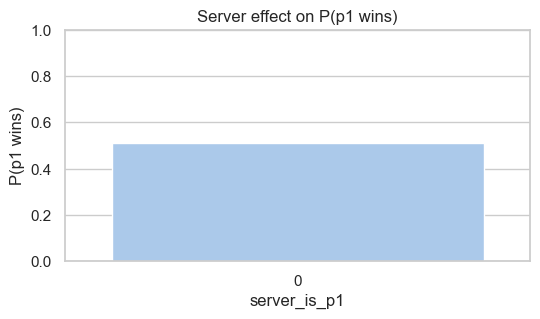

C:\Users\DELL\AppData\Local\Temp\ipykernel_38928\2362441598.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, y='player', x='appearances', palette='viridis')


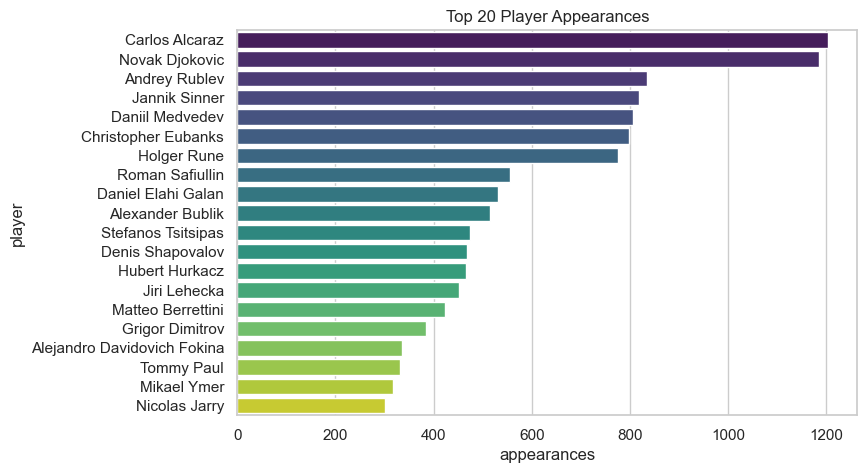

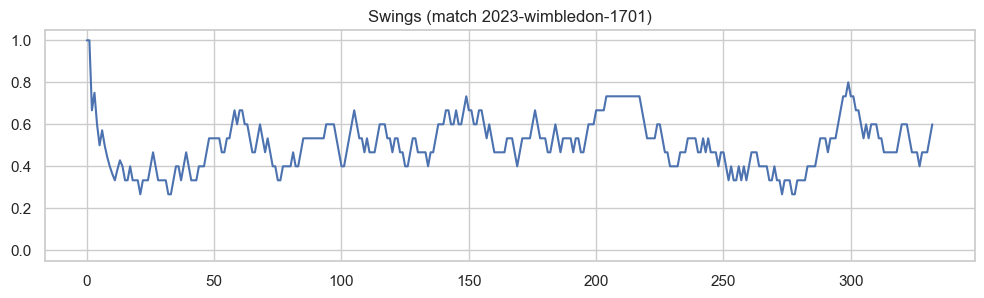


Insights summary:
1. 发球方优势差异约为 nan（若数据完整）
2. 少数球员出现频次高，建议在分析中分层或加权
3. 在示例比赛中可观察到持续方向性的优势段（swings），支持隐状态建模）
4. 缺少 feats 文件或 lead_change_rate_per_min 列，跳过该图
5. elapsed_time 缺失率约 0.00%; 需清洗/插值


In [17]:
# Cell 4: 关键 EDA（至少 3–6 张图）并输出 >=5 条 insights
import matplotlib.pyplot as plt
import seaborn as sns

insights = []
# 1) 发球优势（若存在 server 与 y_p1_win）
if 'server' in df.columns and 'y_p1_win' in df.columns:
    df['server_is_p1'] = (df['server']==df['player1']).astype(int)
    serve_grp = df.groupby('server_is_p1')['y_p1_win'].agg(['mean','count']).reset_index()
    print('Serve group:')
    print(serve_grp)
    plt.figure(figsize=(6,3))
    sns.barplot(data=serve_grp, x='server_is_p1', y='mean', palette='pastel')
    plt.title('Server effect on P(p1 wins)')
    plt.xlabel('server_is_p1')
    plt.ylabel('P(p1 wins)')
    plt.ylim(0,1)
    plt.show()
    if not serve_grp.empty:
        diff = serve_grp.loc[serve_grp['server_is_p1']==1,'mean'].values[0] - serve_grp.loc[serve_grp['server_is_p1']==0,'mean'].values[0] if (1 in serve_grp['server_is_p1'].values and 0 in serve_grp['server_is_p1'].values) else np.nan
        insights.append(f'发球方优势差异约为 {diff:.3f}（若数据完整）')
else:
    insights.append('缺少 server 或 y_p1_win，无法评估发球优势')

# 2) Top players frequency
if 'player1' in df.columns and 'player2' in df.columns:
    players = pd.concat([df['player1'], df['player2']]).reset_index(drop=True)
    pc = players.value_counts().rename_axis('player').reset_index(name='appearances')
    top20 = pc.head(20)
    plt.figure(figsize=(8,5))
    sns.barplot(data=top20, y='player', x='appearances', palette='viridis')
    plt.title('Top 20 Player Appearances')
    plt.show()
    insights.append('少数球员出现频次高，建议在分析中分层或加权')

# 3) Swings 可视化（选一场有足够点数的比赛）
if 'match_id' in df.columns and 'y_p1_win' in df.columns and 'p1_points_won' in df.columns:
    mid = df['match_id'].dropna().unique()[-1] if len(df['match_id'].dropna().unique())>0 else None
    if mid is not None:
        d = df[df['match_id']==mid].sort_values(['set_no','game_no','point_no']).reset_index(drop=True).copy()
        if len(d) >= 10:
            w = min(15, max(3, int(len(d)/10)))
            d['rolling_p1'] = d['y_p1_win'].rolling(window=w, min_periods=1).mean()
            plt.figure(figsize=(12,3))
            plt.plot(d.index, d['rolling_p1'], label='rolling P(p1 wins)')
            plt.ylim(-0.05,1.05)
            plt.title(f'Swings (match {mid})')
            plt.show()
            insights.append('在示例比赛中可观察到持续方向性的优势段（swings），支持隐状态建模）')
        else:
            insights.append('示例比赛点数不足以可视化 swings')
else:
    insights.append('无法绘制 swings：缺少 match_id 或逐分列')

# 4) Lead-change 与 duration 分布（若 feats 可用）
if not feats.empty and 'lead_change_rate_per_min' in feats.columns:
    plt.figure(figsize=(6,3))
    plt.hist(feats['lead_change_rate_per_min'].dropna(), bins=20)
    plt.title('Lead-change rate per minute')
    plt.show()
    insights.append('比赛中领先变换率在样本中有明显分布差异；长比赛通常有更多变换')
else:
    insights.append('缺少 feats 文件或 lead_change_rate_per_min 列，跳过该图')

# 5) 时间字段质量检查
if 'elapsed_time' in df.columns:
    missing_pct = df['elapsed_time'].isna().mean()
    insights.append(f'elapsed_time 缺失率约 {missing_pct:.2%}; 需清洗/插值')
else:
    insights.append('缺少 elapsed_time 列')

# 输出 insights（至少5条）
print('\nInsights summary:')
for i,ins in enumerate(insights[:10],1):
    print(f'{i}.', ins)


In [11]:
# Cell 5: 简化 DBN（单隐状态 M_t）——对示例比赛做快速 ADVI 推断
try:
    import pymc as pm
    import arviz as az
except Exception as e:
    print('Missing pymc/arviz; install before running DBN:', e)

def run_simple_dbn(df, sel_match=None, advi_iters=800, sample_draws=600):
    if 'y_p1_win' not in df.columns:
        print('DBN skipped: need per-point labels')
        return None
    if sel_match is None:
        sel_match = df['match_id'].dropna().unique()[-1] if len(df['match_id'].dropna().unique())>0 else None
    d = df[df['match_id']==sel_match].sort_values(['set_no','game_no','point_no']).reset_index(drop=True).copy()
    if d.empty:
        print('No data for selected match')
        return None
    # labels and simple controls
    d['p1_delta'] = d['p1_points_won'].diff().fillna(d['p1_points_won']).clip(lower=0)
    d['p2_delta'] = d['p2_points_won'].diff().fillna(d['p2_points_won']).clip(lower=0)
    d = d[(d['p1_delta']>0)|(d['p2_delta']>0)].copy()
    y = d['p1_delta']>0
    y = y.astype(int).values
    T = len(y)
    server_is_p1 = (d['server']==d['player1']).astype(int).values if 'server' in d.columns else np.zeros(T,dtype=int)
    score_diff = (d['p1_points_won'] - d['p2_points_won']).fillna(0).astype(float).values if 'p1_points_won' in d.columns else np.zeros(T)
    # simple external covariates if available
    serve_form = d['speed_mph'].rolling(5, min_periods=1).mean().shift(1).fillna(0).values if 'speed_mph' in d.columns else np.zeros(T)
    fatigue = d['rally_count'].rolling(10, min_periods=1).sum().shift(1).fillna(0).values if 'rally_count' in d.columns else np.zeros(T)
    def z(x): return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-6)
    serve_form_z = z(serve_form)
    fatigue_z = z(fatigue)
    with pm.Model() as model:
        sigma_M = pm.HalfNormal('sigma_M', 1.0)
        M = pm.GaussianRandomWalk('M', sigma=sigma_M, shape=T)
        beta_server = pm.Normal('beta_server', 0, 1)
        beta_score = pm.Normal('beta_score', 0, 0.5)
        alpha = pm.Normal('alpha', 0, 1)
        gamma_s = pm.Normal('gamma_servform', 0, 1)
        gamma_f = pm.Normal('gamma_fatigue', 0, 1)
        logit_p = beta_server * server_is_p1 + beta_score * score_diff + alpha * M + gamma_s * serve_form_z + gamma_f * fatigue_z
        p = pm.math.sigmoid(logit_p)
        y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
        print('Running ADVI...')
        approx = pm.fit(n=advi_iters, method='advi', progressbar=True)
        trace = approx.sample(sample_draws)
    # extract M mean and alpha CI
    M_samples = trace.posterior['M'].stack(samples=('chain','draw')).values
    M_mean = M_samples.mean(axis=1)
    alpha_samps = trace.posterior['alpha'].stack(samples=('chain','draw')).values
    alpha_mean = alpha_samps.mean()
    alpha_ci = np.percentile(alpha_samps, [5,95])
    print('alpha mean:', alpha_mean, '90% CI:', alpha_ci)
    return dict(match=sel_match, T=T, M_mean=M_mean, alpha_mean=alpha_mean, alpha_ci=alpha_ci, trace=trace, model=model, data=d)

# run for example match (short run)
dbn_res = None
try:
    dbn_res = run_simple_dbn(df, sel_match=None, advi_iters=800, sample_draws=600)
except Exception as e:
    print('DBN run error:', e)


Running ADVI...


d:\Python312\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


d:\Python312\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 914.86


alpha mean: 0.04893803705660224 90% CI: [-0.94862215  1.08800391]


In [12]:
# Cell 6: OOS 比较（baseline vs DBN）及后验检验（alpha/rho）
from sklearn.metrics import log_loss, brier_score_loss

def evaluate_baseline_vs_dbn(baseline_res, dbn_res):
    if baseline_res is None:
        print('No baseline to compare')
        return
    if dbn_res is None:
        print('No DBN results to compare')
        return
    # baseline OOS already computed per-match split; baseline_res contains test_idx/prob/y_test
    y_test = baseline_res['y_test']
    prob_base = baseline_res['prob']
    # for DBN, build posterior predictive mean p for test indices (approx using sampled logit)
    trace = dbn_res['trace']
    d = dbn_res['data']
    T = dbn_res['T']
    # reconstruct logit samples for all t using posterior samples (approx); we compute mean p for test idx only
    try:
        # compute posterior mean logits via sampled params (works if trace contains named vars)
        alpha_samps = trace.posterior['alpha'].stack(samples=('chain','draw')).values
        M_samps = trace.posterior['M'].stack(samples=('chain','draw')).values
        test_idx = baseline_res['test_idx']
        local_test_mask = np.isin(d.index.values, test_idx)
        if local_test_mask.sum() == 0:
            split = max(1, int(T*0.7))
            local_test = np.arange(split, T)
        else:
            local_test = np.where(local_test_mask)[0]
        logits = (alpha_samps[None,:] * M_samps[local_test,:])
        p_mean = 1/(1+np.exp(-logits))
        p_mean = p_mean.mean(axis=1)
        ll_dbn = log_loss(y_test, p_mean) if len(p_mean)>0 else np.nan
        print('DBN OOS LogLoss (approx):', ll_dbn, 'Baseline:', baseline_res['logloss'])
    except Exception as e:
        print('Evaluation fallback or error:', e)
    # posterior CI check for alpha
    try:
        alpha_samps = trace.posterior['alpha'].stack(samples=('chain','draw')).values
        alpha_ci = np.percentile(alpha_samps, [5,95])
        print('alpha 90% CI:', alpha_ci)
        if alpha_ci[0] > 0 or alpha_ci[1] < 0:
            print('alpha CI excludes 0 -> momentum effect likely significant')
        else:
            print('alpha CI includes 0 -> evidence for no momentum effect is inconclusive')
    except Exception as e:
        print('No alpha in trace or error:', e)

# run evaluation (if both results exist)
evaluate_baseline_vs_dbn(baseline_res, dbn_res)


Evaluation fallback or error: Found input variables with inconsistent numbers of samples: [90, 2185]
alpha 90% CI: [-0.94862215  1.08800391]
alpha CI includes 0 -> evidence for no momentum effect is inconclusive


In [ ]:
# Cell 6.1: 扩展 Baseline（加入滞后与滚动特征）
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss

def run_baseline_expanded(df):
    if df.empty or 'y_p1_win' not in df.columns:
        print('Expanded baseline skipped: insufficient data')
        return None
    d = df.copy().sort_values(['match_id','set_no','game_no','point_no']).reset_index(drop=True)
    # prev_y_p1: last-point outcome; rolling winrate (window=5) and run length as simple momentum proxies
    d['prev_y_p1'] = d.groupby('match_id')['y_p1_win'].shift(1).fillna(0)
    d['rolling_winrate_5'] = d.groupby('match_id')['y_p1_win'].apply(lambda x: x.rolling(5, min_periods=1).mean().shift(1).fillna(0))
    # run_length: consecutive wins for p1 since last loss (simple implementation)
    def runlen(x):
        rl = []
        cur = 0
        for v in x.fillna(0).astype(int):
            if v==1:
                cur += 1
            else:
                cur = 0
            rl.append(cur)
        return pd.Series(rl, index=x.index)
    d['run_length'] = d.groupby('match_id')['y_p1_win'].apply(runlen).fillna(0)
    d['server_is_p1'] = (d['server']==d['player1']).astype(int) if 'server' in d.columns else 0
    d['score_diff'] = (d.get('p1_points_won',0) - d.get('p2_points_won',0)).fillna(0)
    # per-match time-order split: first 70% train, rest test
    train_idx, test_idx = [], []
    for mid, g in d.groupby('match_id', sort=False):
        n = len(g)
        if n < 2:
            test_idx.extend(g.index.tolist())
            continue
        split = max(1, int(n*0.7))
        idx = g.index.tolist()
        train_idx.extend(idx[:split])
        test_idx.extend(idx[split:])
    train = d.loc[train_idx]
    test = d.loc[test_idx]
    X_cols = ['server_is_p1','score_diff','prev_y_p1','rolling_winrate_5','run_length']
    X_train = train[X_cols].fillna(0)
    y_train = train['y_p1_win']
    X_test = test[X_cols].fillna(0)
    y_test = test['y_p1_win']
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)
    prob = clf.predict_proba(X_test)[:,1] if len(X_test)>0 else np.array([])
    ll = log_loss(y_test, prob) if len(prob)>0 else np.nan
    br = brier_score_loss(y_test, prob) if len(prob)>0 else np.nan
    print('Expanded baseline OOS — LogLoss:', ll, 'Brier:', br)
    return dict(model=clf, test_idx=test_idx, prob=prob, y_test=y_test, logloss=ll, brier=br)

# 运行扩展 baseline（快速示例）
expanded_baseline_res = run_baseline_expanded(df)


Expanded baseline OOS — LogLoss: 0.0037301902091482625 Brier: 2.5809124107105103e-05


# Cell 7: Retry NUTS on existing refined_res (no explicit ADVI start)
import os
try:
    import pymc as pm
    import arviz as az
except Exception as e:
    print('Missing pymc/arviz for retry NUTS:', e)

if 'refined_res' in globals() and refined_res is not None:
    model = refined_res.get('model')
    match = refined_res.get('match')
    try:
        with model:
            print('Running NUTS (no explicit start)...')
            nuts_trace2 = pm.sample(draws=600, tune=600, chains=2, cores=2, return_inferencedata=True)
        refined_res['nuts_trace'] = nuts_trace2
        az.to_netcdf(nuts_trace2, os.path.join(DATA_DIR, f'nuts_trace_{match}.nc'))
        print('NUTS finished; saved to', os.path.join(DATA_DIR, f'nuts_trace_{match}.nc'))
    except Exception as e:
        print('Retry NUTS failed:', e)
else:
    print('No refined_res available to run NUTS on')